# lab 2

In this lab, we're going to run through the mechanics of simulating/analyzing the dynamics of a linear model. We're using the data from the model of teasel ([*Diptacus* species](https://en.wikipedia.org/wiki/Dipsacus)) in the textbook.

Import required libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import transgraph as tg
## limit the number of decimal places printed in output of numpy objects
np.set_printoptions(precision=3)  

Set up the matrix $M$ as a two-dimensional array: `((a11,a12,...),(a21,a22,...),...,(an1,an2))` (the third set of parentheses belongs to the `np.array()` function).

In [2]:
M = np.array(((0,0,0,0,0,322.38),
              (0.966,0,0,0,0,0),
              (0.013,0.010,0.125,0,0,3.448),
              (0.007,0,0.125,0.238,0,30.17),
              (0.008,0,0,0.245,0.167,0.862),
              (0,0,0,0.023,0.75,0)))
print(M)

[[  0.000e+00   0.000e+00   0.000e+00   0.000e+00   0.000e+00   3.224e+02]
 [  9.660e-01   0.000e+00   0.000e+00   0.000e+00   0.000e+00   0.000e+00]
 [  1.300e-02   1.000e-02   1.250e-01   0.000e+00   0.000e+00   3.448e+00]
 [  7.000e-03   0.000e+00   1.250e-01   2.380e-01   0.000e+00   3.017e+01]
 [  8.000e-03   0.000e+00   0.000e+00   2.450e-01   1.670e-01   8.620e-01]
 [  0.000e+00   0.000e+00   0.000e+00   2.300e-02   7.500e-01   0.000e+00]]


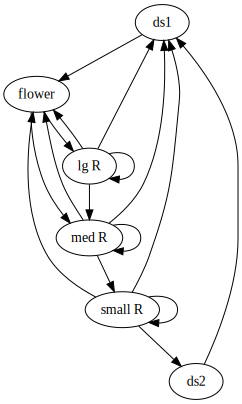

In [3]:
cnames = ["ds1","ds2","small R","med R","lg R","flower"] ## compartment names
tg.transmat_to_graph(M,cnames)  ## draw a transition diagram

The life stages are (1-year dormant seeds; 2-year dormant seeds; small rosettes; medium rosettes; large rosettes; flowering). Two points to notice:

- the first row represents fecundity/birth of new plants: only the last (largest) stage can contribute, but each individual contributes a lot (322 new plants).
- plants always revert to one of the rosette stages after flowering ($\mathbf M(6,6)=0$) [I'm indexing from zero so my Python-brain doesn't explode]

Let's see what happens if we start from a single dormant seed.

In [ ]:
start = np.array((1,0,0,0,0,0))

The simple way to solve this computationally is with a `for` loop. How big does the population get after 200 time steps?

In [ ]:
x = start
for t in range(200):
    x = M.dot(x)
print(x)

We can do the same thing with a matrix-power operator: first we compute $\mathbf M^{200}$, then multiply it by $x(0)$ (we could also do it all in one step):

In [ ]:
M200 = np.linalg.matrix_power(M,200)
x200 = M200.dot(start)
print(x200)

The results are visually the same as before (we could use `np.allclose(x,x200)` to check that all of the elements are nearly identical - we don't expect them to be exactly the same, because floating-point computations are involved).

Calculate eigenvalues and eigenvectors:

In [ ]:
e1 = np.linalg.eig(M)

Print the eigenvalues (numpy returns the eigenvalues as a complex-valued array: it uses `j`, rather than `i`, to denote $\sqrt{-1}$. This is standard notation in engineering.)

In [ ]:
e1[0]

Compute the modulus of the eigenvalues: `numpy` uses `abs` for modulus as well as absolute value

In [ ]:
np.abs(e1[0])

In [ ]:
np.abs(e1[0][1]/e1[0][0])

Now let's look at the eigenvector associated with the dominant eigenvalue.  This is the first (zeroth) *column* of the eigenvector matrix, which we extract using `[:,0]` (if this is unfamiliar to you, you can search for "slicing" in my [math 1mp notes](http://bbolker.github.io/math1mp/notes/week1.html) or search for "Python slicing tutorial" on the web - or ask your TA)

In [ ]:
e10 = e1[1][:,0]
print(e10)

Because the eigenvector matrix contains some complex values, the first column is stored as complex, even though the imaginary parts are all zero.  We can extract the real part:

In [ ]:
e10 = np.real(e10)
print(e10)

If we want this to sum to 1 (so it will represent the *stable stage distribution*), we can divide it by its total:

In [ ]:
print(e10/np.sum(e10))

## Pictures

Now we're going to run the model again, but keep track of the values for all time steps:

In [ ]:
tvec = np.arange(50)
x = np.zeros((len(tvec),len(start)))  ## set up a 2D array of zeros for the results
x[0,:] = start
for t in tvec[1:]:
        x[t,:] = M.dot(x[t-1,:])

For any linear model with an unstable zero equilibrium (i.e. geometric growth) and a dominant eigenvalue that is more than slightly above 1, the numbers will get ridiculous if we run it for very long (recall the population sizes of $10^{70}$ we saw above at $t=200$). It's convenient to plot such geometric growth curves on a *semi-log* scale, i.e. with a log-y axis:

In [ ]:
%matplotlib inline
plt.semilogy(tvec,x);  ## "semi-log-y" (i.e. y is on the log scale)
plt.xlabel("time")
plt.ylabel("population (compartment) size");

It would be nice to know the *proportion* of the population in each category (which is supposed to equilibrate to the stable stage distribution). We can use a `for` loop to divide each row (the population sizes at a specified time) by its total (the total population size):


In [ ]:
x_scaled = x  ## copy array to get ready
for r in range(x.shape[0]):
    x_scaled[r,:] = x[r,:]/np.sum(x[r,:])

If your brain is full now, you can skim over the next few chunks. It's more compact to compute the vector of total population sizes (i.e. the row sums) all at once, and then divide the population table by the row-sum vector. When applied to a 2D array, `np.sum()` computes the entire sum ($\sum_{i,j} x_{ij}$) by default, but we can use the `axis=` argument to compute column sums (`axis=0`) or row sums (`axis=1`) instead.

In [ ]:
rowsums = np.sum(x,axis=1) 

Now we use `np.newaxis` to tell NumPy that we want a column vector, i.e. a $n \times 1$ array. 

In [ ]:
rowtab = rowsums[:,np.newaxis] 
print(rowtab.shape)

When we ask NumPy to divide a matrix by a column vector, it knows the right thing to do (i.e., divide each row of the matrix by the corresponding element of the vector, just as we did above).

In [ ]:
x_scaled = x/rowtab ## same as above

Now we can plot the results:

In [ ]:
%matplotlib inline
plt.plot(tvec,x_scaled)
plt.xlabel("time")
plt.ylabel("proportion of population");
ncat = x_scaled.shape[1] ## number of columns
plt.legend(range(ncat));